# Downloading, pre-processing and running cNMF on marjanovic et. al 2020 data
1. Obtaining the data and creating AnnData object
2. filtering genes, showing key statistics and selecting joint highly variable genes (jHVGs)
3. Splitting the dataset by timepoints
3. Running consensus NMF (cNMF) per timepoint
4. Selecting parameters for the cNMF
5. Running the comparator for adjacent time points



In [20]:
%%time

#debug jupyter:
%load_ext autoreload
%autoreload 2

#debug IDE:
from importlib import reload

import sys
import os
import time
import warnings
from urllib.request import urlretrieve

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

sc.settings.n_jobs = -1

from gepdynamics import _utils, _constants, cnmf, pfnmf, comparator, plotting

_utils.cd_proj_home()
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/cs/labs/mornitzan/yotamcon/gep-dynamics
CPU times: user 1.95 ms, sys: 934 µs, total: 2.89 ms
Wall time: 4.98 ms


### 1. Downloading or loading AnnData object

In [4]:
results_dir = _utils.set_dir('results')
results_dir = _utils.set_dir(results_dir.joinpath('marjanovic'))
data_dir = _utils.set_dir('data')

In [3]:
%%time

orig_adata_path = data_dir.joinpath('marjanovic_mmLungPlate.h5ad')

if not orig_adata_path.exists():  # create the original adata if it doesn't exist
    print('Source AnnData object does not exist, creating it')
    # directories for file download:
    data_dir = _utils.set_dir('data')
    GSE_dir = _utils.set_dir(data_dir.joinpath('GSE154989'))
    
    # GEO server prefix for mmLungPlate SubSeries GSE154989
    ftp_address = 'https://ftp.ncbi.nlm.nih.gov/geo/series/GSE154nnn/GSE154989/suppl/'

    #filenames
    f_rawCount = GSE_dir.joinpath('GSE154989_mmLungPlate_fQC_dSp_rawCountOrig.h5')
    f_geneTable = GSE_dir.joinpath('GSE154989_mmLungPlate_fQC_geneTable.csv.gz')
    f_smpTable = GSE_dir.joinpath('GSE154989_mmLungPlate_fQC_smpTable.csv.gz')
    f_smp_annot = GSE_dir.joinpath('GSE154989_mmLungPlate_fQC_dZ_annot_smpTable.csv.gz')

    ftp_address = 'https://ftp.ncbi.nlm.nih.gov/geo/series/GSE154nnn/GSE154989/suppl/'

    # downloading if needed:
    if not f_rawCount.exists():
        urlretrieve(ftp_address + f_rawCount.name, f_rawCount)
    
    if not f_geneTable.exists():
        urlretrieve(ftp_address + f_geneTable.name, f_geneTable)
    
    if not f_smpTable.exists():
        urlretrieve(ftp_address + f_smpTable.name, f_smpTable)
    
    if not f_smp_annot.exists():
        urlretrieve(ftp_address + f_smp_annot.name, f_smp_annot)
    
    # reading the files
    sparse_counts = _utils.read_matlab_h5_sparse(f_rawCount)
    
    gene_ids = pd.read_csv(f_geneTable, index_col=None)
    gene_ids.index = gene_ids.ensgID.str.split('.').str[0]
    gene_ids.index.name = None
    smp_ids = pd.read_csv(f_smpTable, index_col=0)
    smp_annotation = pd.read_csv(f_smp_annot, index_col=0)
    
    # constructing the adata
    adata = sc.AnnData(X=sparse_counts.astype(np.float32), var=gene_ids, obs=smp_ids)

    # remove genes with 0 counts
    adata = adata[:, adata.X.sum(axis=0) > 0].copy()
    
    adata.obs['clusterK12'] = smp_annotation.clusterK12.astype('category')
    
    adata.obsm['X_tsne'] = smp_annotation[['tSNE_1', 'tSNE_2']].values
    adata.obsm['X_phate'] = smp_annotation[['phate_1', 'phate_2']].values
    adata.write(orig_adata_path)

    del sparse_counts, gene_ids, smp_ids, smp_annotation
else:
    adata = sc.read_h5ad(orig_adata_path)

adata

CPU times: user 259 ms, sys: 258 ms, total: 516 ms
Wall time: 2.37 s


AnnData object with n_obs × n_vars = 3891 × 46184
    obs: 'plateID', 'mouseID', 'timesimple', 'typeID', 'clusterK12'
    var: 'geneID', 'ensgID', 'geneSymbol', 'length'
    obsm: 'X_phate', 'X_tsne'

In [4]:
adata.obs.timesimple.replace({'01_T_early_ND': '00_All_early', '02_KorKP_early_ND': '00_All_early'}, inplace=True)
adata.obs['timesimple'].cat.categories

Index(['00_All_early', '04_K_12w_ND', '05_K_30w_ND', '06_KP_12w_ND',
       '07_KP_20w_ND', '08_KP_30w_ND'],
      dtype='object')

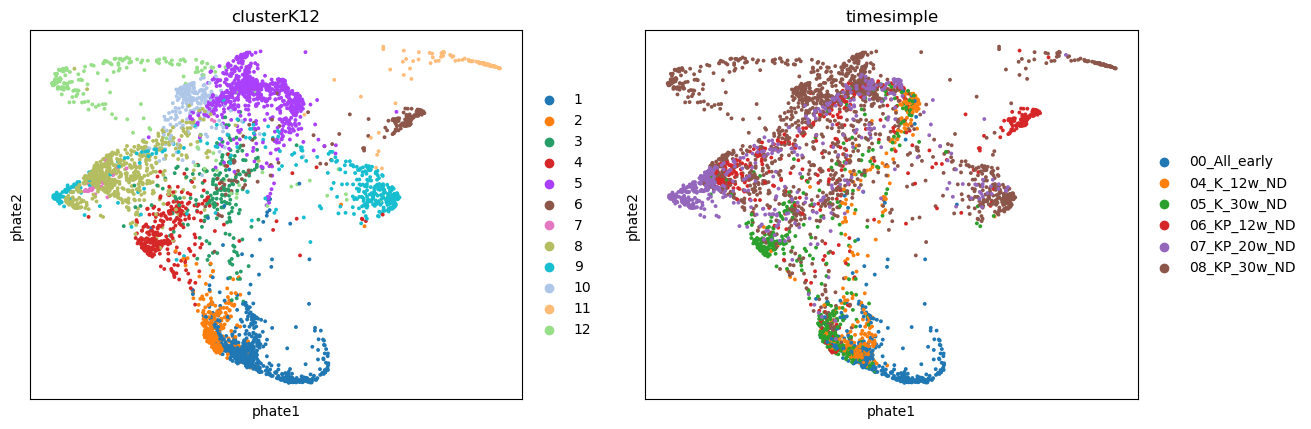

In [5]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    
    sc.external.pl.phate(adata, color=['clusterK12', 'timesimple'])

adata.uns['timesimple_colors_dict'] = dict(zip(adata.obs['timesimple'].cat.categories, adata.uns['timesimple_colors']))
adata.uns['clusterK12_colors_dict'] = dict(zip(adata.obs['clusterK12'].cat.categories, adata.uns['clusterK12_colors']))

In [6]:
pd.crosstab(adata.obs.timesimple, adata.obs.clusterK12)

clusterK12,1,2,3,4,5,6,7,8,9,10,11,12
timesimple,,,,,,,,,,,,
00_All_early,295,39,7,0,7,0,0,0,0,0,0,0
04_K_12w_ND,240,54,34,8,117,0,0,1,1,0,0,0
05_K_30w_ND,82,133,32,163,71,0,1,15,8,0,0,0
06_KP_12w_ND,4,40,34,17,108,109,8,142,18,9,2,0
07_KP_20w_ND,6,2,13,48,119,10,16,189,134,0,1,0
08_KP_30w_ND,25,17,73,79,343,39,11,270,214,208,86,189


37 mitochondrial genes


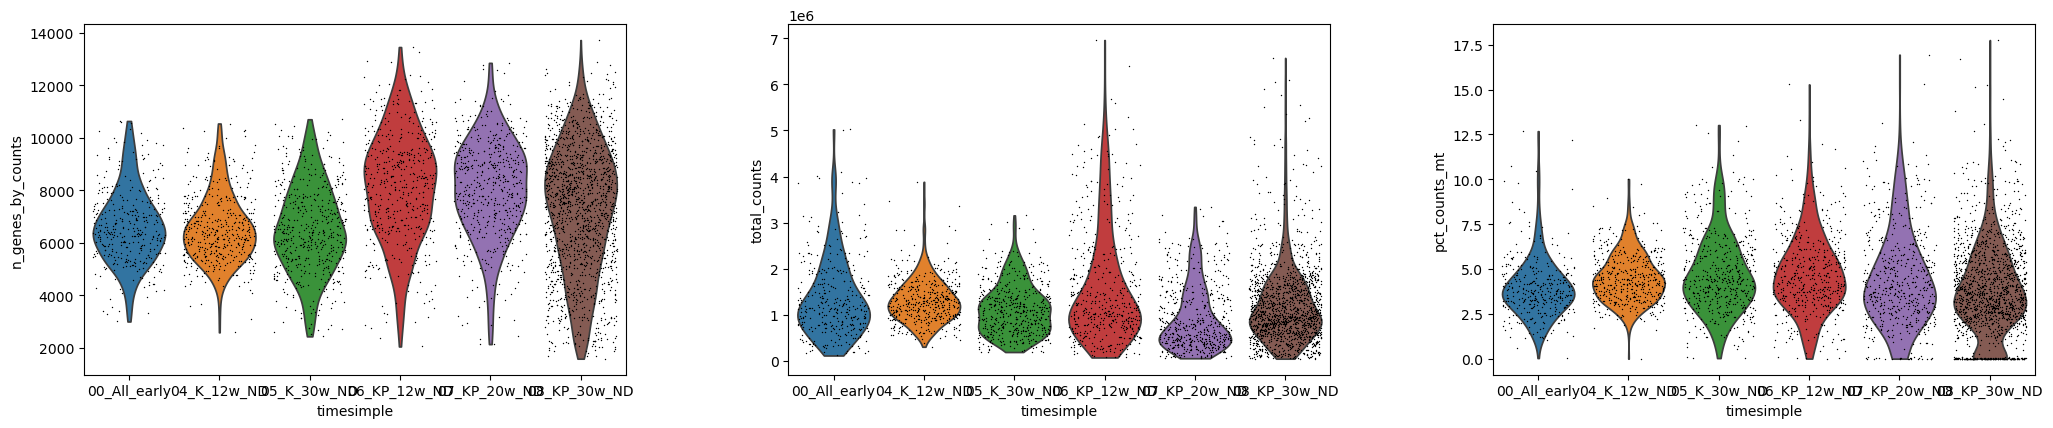

In [7]:
adata.var['mt'] = adata.var.geneSymbol.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
print(f"{np.sum(adata.var['mt'])} mitochondrial genes")
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    
    sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
                 jitter=0.4, multi_panel=True, groupby='timesimple')

/tmp/ipykernel_676785/3987952678.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_676785/3987952678.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



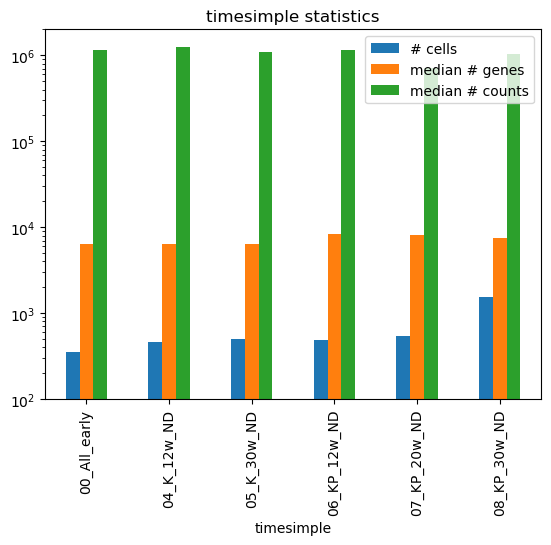

In [8]:
column_of_interest = 'timesimple'

stats_df = adata.obs.loc[:, [column_of_interest, 'n_genes_by_counts', 'total_counts']].groupby(
    [column_of_interest]).median()

stats_df = pd.concat([adata.obs.groupby([column_of_interest]).count().iloc[:, 0],
                      stats_df], axis=1)
stats_df.columns = ['# cells', 'median # genes', 'median # counts']

stats_df.plot(kind='bar', title=f'{column_of_interest} statistics', log=True, ylim=((1e2, 2e6)))
plt.show()
del column_of_interest, stats_df

/cs/labs/mornitzan/yotamcon/conda/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_qc.py:89: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



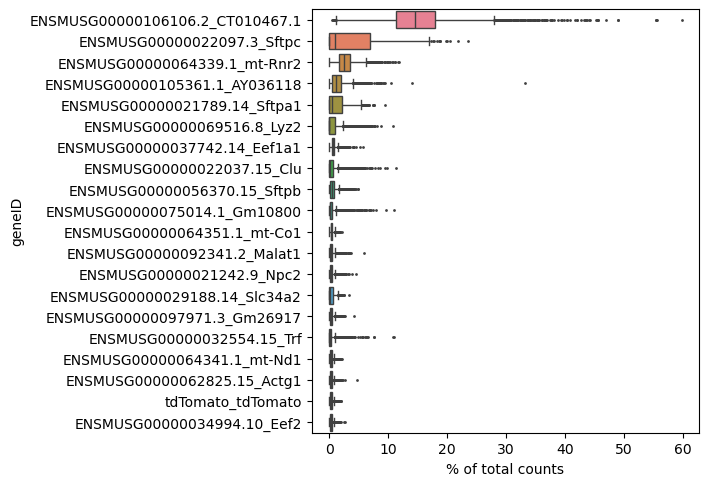

In [9]:
sc.pl.highest_expr_genes(adata, n_top=20, gene_symbols='geneID')

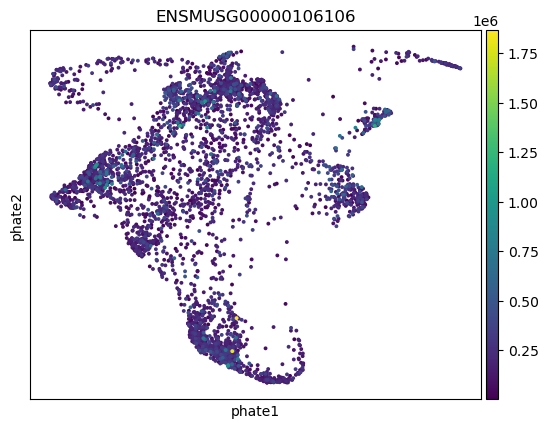

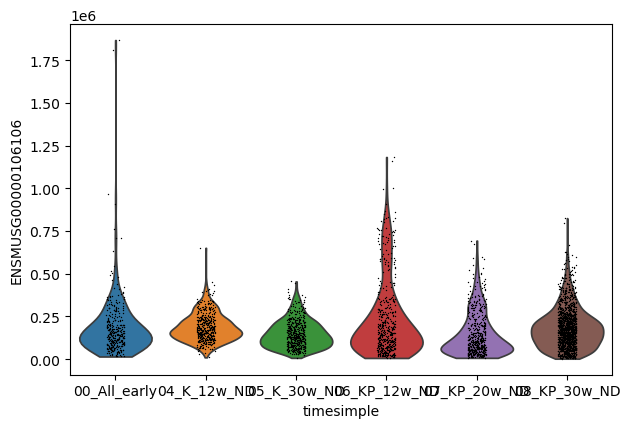

In [14]:
# rRNA overlapping gene 
sc.external.pl.phate(adata, color='ENSMUSG00000106106')
sc.pl.violin(adata, keys='ENSMUSG00000106106', groupby='timesimple')

### 2. Filter genes and plot basic statistics
Cells with low number of genes were already filtered

In [15]:
%%time
print(f'before filtering shape was {adata.X.shape}')

# filter cells with high amount of mitochondrial genes or extremely high counts
adata = adata[(adata.obs.pct_counts_mt < 10) & (adata.obs.total_counts < 5E6)].copy()

# filter ribosomal and mitochondrial genes:
adata = adata[:, ~(adata.var.geneSymbol.str.contains('^mt-') |
    adata.var.geneSymbol.str.contains('^Mrp[ls]\d') |
    adata.var.geneSymbol.str.contains('^Rp[ls]\d') |
    (adata.var_names == 'ENSMUSG00000106106'))].copy()

# filtering genes with very low abundance
sc.pp.filter_genes(adata, min_cells=np.round(adata.shape[0] / 1000))

# re-setting general statistics for counts abundance
adata.obs.n_genes_by_counts = np.count_nonzero(adata.X.toarray(), axis=1)
adata.obs.total_counts = adata.X.toarray().sum(axis=1)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=_constants.NUMBER_HVG)

print(f'after filtering shape is {adata.X.shape}')

before filtering shape was (3891, 46184)
after filtering shape is (3797, 37051)
CPU times: user 4.34 s, sys: 1.39 s, total: 5.74 s
Wall time: 8.6 s


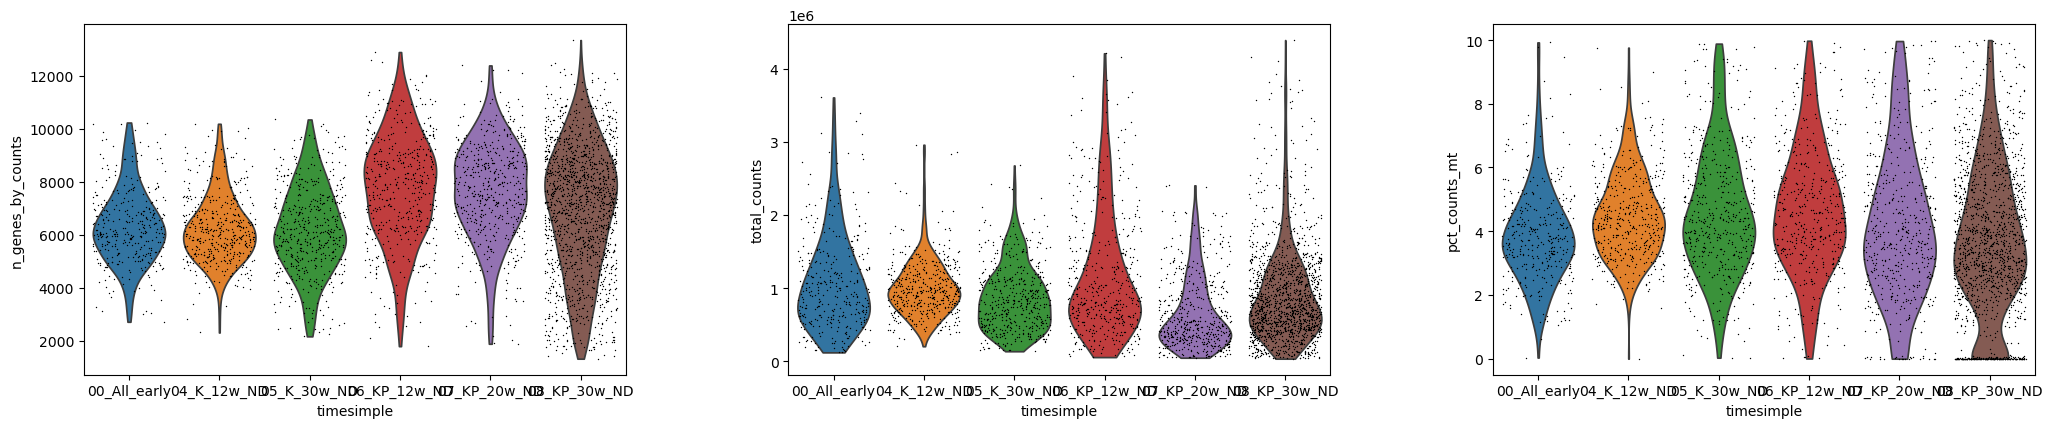

In [16]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    
    sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
                 jitter=0.4, multi_panel=True, groupby='timesimple')

/tmp/ipykernel_676785/3987952678.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_676785/3987952678.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



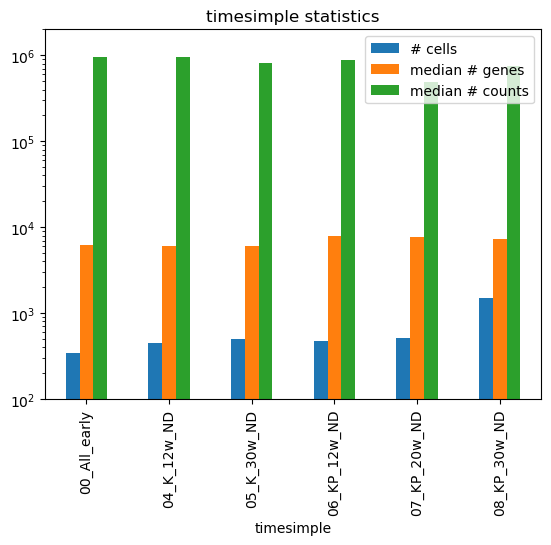

In [17]:
column_of_interest = 'timesimple'

stats_df = adata.obs.loc[:, [column_of_interest, 'n_genes_by_counts', 'total_counts']].groupby(
    [column_of_interest]).median()

stats_df = pd.concat([adata.obs.groupby([column_of_interest]).count().iloc[:, 0],
                      stats_df], axis=1)
stats_df.columns = ['# cells', 'median # genes', 'median # counts']

stats_df.plot(kind='bar', title=f'{column_of_interest} statistics', log=True, ylim=((1e2, 2e6)))
plt.show()
del column_of_interest, stats_df

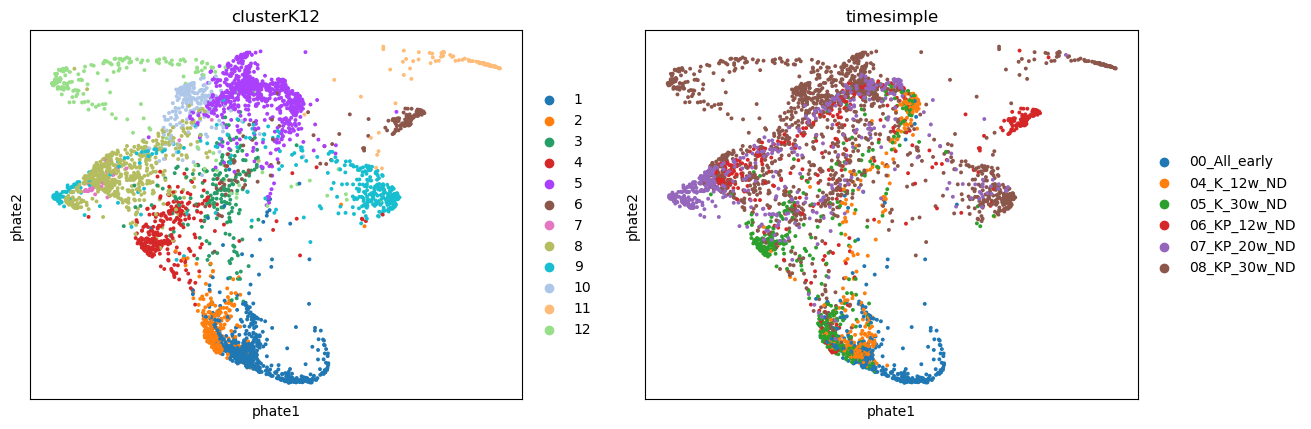

In [18]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    
    sc.external.pl.phate(adata, color=['clusterK12', 'timesimple'])

In [19]:
pd.crosstab(adata.obs.timesimple, adata.obs.clusterK12)

clusterK12,1,2,3,4,5,6,7,8,9,10,11,12
timesimple,,,,,,,,,,,,
00_All_early,289,39,7,0,7,0,0,0,0,0,0,0
04_K_12w_ND,239,54,34,8,117,0,0,1,1,0,0,0
05_K_30w_ND,82,127,31,161,71,0,1,13,8,0,0,0
06_KP_12w_ND,4,40,33,17,107,104,8,133,17,8,2,0
07_KP_20w_ND,6,2,13,46,118,9,16,176,132,0,1,0
08_KP_30w_ND,24,17,71,77,338,39,9,252,213,201,85,189


In [20]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    _utils.joint_hvg_across_stages(adata, obs_category_key='timesimple', n_top_genes=5000)
adata.var

,geneID,ensgID,geneSymbol,length,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm,timesimple_max_var_norm,joint_highly_variable
ENSMUSG00000000001,ENSMUSG00000000001.4_Gnai3,ENSMUSG00000000001.4,Gnai3,3262.000,False,3157,242.593414,18.864045,9.439310e+05,3081,False,NaN,238.487753,1.111309e+05,0.919581,0.967679,False
ENSMUSG00000000003,ENSMUSG00000000003.15_Pbsn,ENSMUSG00000000003.15,Pbsn,799.500,False,5,0.003598,99.871498,1.400000e+01,5,False,NaN,0.003687,1.526564e-02,1.420609,1.420609,False
ENSMUSG00000000028,ENSMUSG00000000028.14_Cdc45,ENSMUSG00000000028.14,Cdc45,1574.000,False,365,8.837885,90.619378,3.438821e+04,351,False,NaN,8.859423,2.363279e+03,1.597923,2.424523,True
ENSMUSG00000000031,ENSMUSG00000000031.15_H19,ENSMUSG00000000031.15,H19,1268.600,False,23,3.876859,99.408892,1.508486e+04,22,True,268.0,3.954137,1.285917e+04,3.929442,3.929442,True
ENSMUSG00000000049,ENSMUSG00000000049.11_Apoh,ENSMUSG00000000049.11,Apoh,665.500,False,155,3.832691,96.016448,1.491300e+04,149,True,775.0,3.800105,1.546848e+03,2.841224,3.084494,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000114962,ENSMUSG00000114962.1_AC126939.4,ENSMUSG00000114962.1,AC126939.4,743.000,False,263,0.005112,93.240812,1.989004e+01,253,False,NaN,0.005180,4.341623e-03,0.213936,0.633487,False
ENSMUSG00000114967,ENSMUSG00000114967.1_AC161884.2,ENSMUSG00000114967.1,AC161884.2,227.000,False,41,0.039324,98.946286,1.530100e+02,40,False,NaN,0.039244,3.912414e-01,0.521800,1.217894,False
ENSMUSG00000114968,ENSMUSG00000114968.1_AC130217.2,ENSMUSG00000114968.1,AC130217.2,2990.000,False,42,0.578473,98.920586,2.250840e+03,41,False,NaN,0.563466,7.400340e+01,2.227440,2.227440,True
kallistoKRASG12D,kallistoKRASG12D_KRASG12D,kallistoKRASG12D,KRASG12D,422.403,False,1201,6.795740,69.133899,2.644224e+04,1162,False,NaN,6.413899,3.660532e+02,0.370166,0.508119,False


In [8]:
prepared_adata_path = results_dir.joinpath('full.h5ad')

if not prepared_adata_path.exists():
    # Removing h5ad trouble saving element before saving
    adata.uns.pop('clusterK12_colors_dict', None)
    adata.write_h5ad(prepared_adata_path)
else:
    print('reading adata...')
    adata = sc.read_h5ad(prepared_adata_path)
    # restoring h5ad trouble saving element
    adata.uns['clusterK12_colors_dict'] = dict(zip(adata.obs['clusterK12'].cat.categories, adata.uns['clusterK12_colors']))

adata

reading adata...


AnnData object with n_obs × n_vars = 3797 × 37051
    obs: 'plateID', 'mouseID', 'timesimple', 'typeID', 'clusterK12', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'geneID', 'ensgID', 'geneSymbol', 'length', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'timesimple_max_var_norm', 'joint_highly_variable'
    uns: 'clusterK12_colors', 'hvg', 'timesimple_colors', 'timesimple_colors_dict', 'clusterK12_colors_dict'
    obsm: 'X_phate', 'X_tsne'

### 3. Splitting the adata by "timesimple"

In [22]:
short_names_dict = {
    '00_All_early': 'T0',
    '04_K_12w_ND': 'K12',
    '05_K_30w_ND': 'K30',
    '06_KP_12w_ND': 'KP12',
    '07_KP_20w_ND': 'KP20',
    '08_KP_30w_ND': 'KP30'}

In [23]:
%%time

column_of_interest = 'timesimple'
categories = adata.obs[column_of_interest].cat.categories

split_adatas_dir = _utils.set_dir(results_dir.joinpath(f'split_{column_of_interest}'))

for cat in categories:
    if not split_adatas_dir.joinpath(f'{cat}.h5ad').exists():
        print(f'working on {cat}')
        tmp = adata[adata.obs[column_of_interest] == cat].copy()

        tmp.uns['name'] = f'{cat}'   # full name
        tmp.uns['sname'] = short_names_dict[cat]  # short name

        # correcting the gene counts
        sc.pp.filter_genes(tmp, min_cells=0)
        sc.pp.filter_genes(tmp, min_counts=0)
        
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UserWarning)
            sc.pp.highly_variable_genes(tmp, flavor='seurat_v3', n_top_genes=5000)

        # Removing h5ad trouble saving element before saving
        tmp.uns.pop('clusterK12_colors_dict', None)
        tmp.write_h5ad(split_adatas_dir.joinpath(f'{cat}.h5ad'))

        del tmp
    else:
        print(f'{cat} split adata exists')

Directory "results/marjanovic/split_timesimple" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results/marjanovic/split_timesimple
working on 00_All_early
working on 04_K_12w_ND
working on 05_K_30w_ND
working on 06_KP_12w_ND
working on 07_KP_20w_ND
working on 08_KP_30w_ND
CPU times: user 9.5 s, sys: 789 ms, total: 10.3 s
Wall time: 8.11 s


### 4. Running multiple NMF iterations

In [5]:
cnmf_dir = _utils.set_dir(results_dir.joinpath('cnmf'))
beta_loss = 'kullback-leibler'
tpm_target_sum = 1_000_000

In [25]:
%%time

ks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

for cat in categories:
    print(f'Starting on {cat}, time is {time.strftime("%H:%M:%S", time.localtime())}')
    tmp = sc.read_h5ad(split_adatas_dir.joinpath(f'{cat}.h5ad'))
    
    c_object = cnmf.cNMF(cnmf_dir, cat)
    
    # Variance normalized version of the data
    X = _utils.subset_and_normalize_for_nmf(tmp, method='variance_cap')
    
    c_object.prepare(X, ks, n_iter=150, new_nmf_kwargs={
        'tol': _constants.NMF_TOLERANCE, 'beta_loss': beta_loss, 'max_iter': 1000})
    
    c_object.factorize(0, 1, gpu=True)
    
    c_object.combine()
    
    del tmp, X

Starting on 00_All_early, time is 13:36:13
Combining factorizations for k=1.
Combining factorizations for k=2.
Combining factorizations for k=3.
Combining factorizations for k=4.
Combining factorizations for k=5.
Combining factorizations for k=6.
Combining factorizations for k=7.
Combining factorizations for k=8.
Combining factorizations for k=9.
Combining factorizations for k=10.
Combining factorizations for k=11.
Combining factorizations for k=12.
Starting on 05_K_30w_ND, time is 13:59:04
Combining factorizations for k=1.
Combining factorizations for k=2.
Combining factorizations for k=3.
Combining factorizations for k=4.
Combining factorizations for k=5.
Combining factorizations for k=6.
Combining factorizations for k=7.
Combining factorizations for k=8.
Combining factorizations for k=9.
Combining factorizations for k=10.
Combining factorizations for k=11.
Combining factorizations for k=12.
Starting on 06_KP_12w_ND, time is 14:10:42
Combining factorizations for k=1.
Combining factor

In [26]:
%%time
for cat in categories:
    print(f'Starting on {cat}, time is {time.strftime("%H:%M:%S", time.localtime())}')
    c_object = cnmf.cNMF(cnmf_dir, cat)
    for thresh in [0.5, 0.4]:
        print(f'working on threshold {thresh}')
        c_object.k_selection_plot(density_threshold=thresh, nmf_refitting_iters=500, 
                                  consensus_method='mean',
                                  close_fig=True, show_clustering=True, gpu=True)
        # printing the selected knee point
        df = cnmf.load_df_from_npz(c_object.paths['k_selection_stats_dt'] % c_object.convert_dt_to_str(thresh))
        pos = len(df) - 4
        for i in range(5):
            print(cnmf.find_knee_point(df.prediction_error[:pos + i], df.k_source[:pos + i]), end=", ")
        print()

Starting on 00_All_early, time is 15:01:21
working on threshold 0.5
3.0, 3.0, 3.0, 4.0, 4.0, 
working on threshold 0.4
3.0, 4.0, 4.0, 5.0, 5.0, 
Starting on 04_K_12w_ND, time is 15:03:00
working on threshold 0.5
3.0, 3.0, 4.0, 4.0, 4.0, 
working on threshold 0.4
3.0, 3.0, 4.0, 3.0, 3.0, 
Starting on 05_K_30w_ND, time is 15:04:42
working on threshold 0.5
3.0, 4.0, 4.0, 4.0, 4.0, 
working on threshold 0.4
3.0, 4.0, 4.0, 4.0, 4.0, 
Starting on 06_KP_12w_ND, time is 15:06:23
working on threshold 0.5
4.0, 4.0, 4.0, 4.0, 5.0, 
working on threshold 0.4
4.0, 4.0, 4.0, 4.0, 5.0, 
Starting on 07_KP_20w_ND, time is 15:08:11
working on threshold 0.5
3.0, 3.0, 3.0, 5.0, 5.0, 
working on threshold 0.4
3.0, 3.0, 3.0, 5.0, 5.0, 
Starting on 08_KP_30w_ND, time is 15:10:07
working on threshold 0.5
3.0, 4.0, 4.0, 4.0, 4.0, 
working on threshold 0.4
4.0, 4.0, 4.0, 4.0, 4.0, 
CPU times: user 37min 29s, sys: 33min 51s, total: 1h 11min 21s
Wall time: 10min 47s


## 5. Selecting decomposition ranks for cNMF using knee-point and silhouette


In [6]:
if 'split_adatas' not in globals():
    print('creating split_adatas')
    
    split_adatas_dir = _utils.set_dir(results_dir.joinpath(f'split_{column_of_interest}'))
    split_adatas = {}
    
    for cat in categories:
        tmp = sc.read_h5ad(split_adatas_dir.joinpath(f'{cat}.h5ad'))
        
        # restoring h5ad trouble saving element
        tmp.uns['clusterK12_colors_dict'] = dict(zip(tmp.obs['clusterK12'].cat.categories, tmp.uns['clusterK12_colors']))
        
        split_adatas[cat] = tmp

if 'decompositions' not in globals():
    decompositions = {}
    for cat in categories:
        decompositions[cat] = {}

creating split_adatas


NameError: name 'column_of_interest' is not defined

#### Examining programs dynamics by rank


In [ ]:
%%time
threshold = 0.5

k_min = 2
k_max = 8

for cat in categories:
    print(f'Working on {cat}')
    tmp = split_adatas[cat]
    
    c_object = cnmf.cNMF(cnmf_dir, cat)
    
    for k in range(k_min, k_max + 1):
        if k in decompositions[cat].keys():
            continue

        print(f'Working on k={k}')
        try:
            usages, spectra = c_object.get_consensus_usages_spectra(k, density_threshold=threshold)
        except FileNotFoundError:
            print(f'Calculating consensus NMF for k={k}')
            c_object.consensus(k, density_threshold=threshold, gpu=True, verbose=True,
                               consensus_method='mean',
                               nmf_refitting_iters=1000, show_clustering=False)

            usages, spectra = c_object.get_consensus_usages_spectra(k, density_threshold=threshold)
            
        # X ~ W @ H, transpose for cells to be columns
        loss_per_cell = pfnmf.calc_beta_divergence(
            c_object.X.T, W = spectra.T, H = usages.T, per_column=True)
    
        res = comparator.NMFResult(
            name=f'{tmp.uns["sname"]}_k{k}',
            loss_per_cell=loss_per_cell,
            rank=k,
            W=usages,
            H=spectra)
        
        comparator.NMFResultBase.calculate_gene_coefficients_list(
            tmp, [res], target_sum=1_000_000, target_variance=tmp.var['variances_norm'].values)
        
        decompositions[cat][k] = res
    
    print()

np.savez(results_dir.joinpath('decompositions.npz'), obj=decompositions)

In [33]:
decomposition_images = _utils.set_dir(split_adatas_dir.joinpath("images"))

tsc_threshold: float = 0.3
tsc_truncation_level: int = 500

for cat in categories:
    results = [decompositions[cat][i] for i in range(k_min, k_max + 1)]
    names_list = [res.name.split('_')[1] for res in results]
    ks, joint_names, joint_usages, joint_labels = comparator.NMFResultBase.aggregate_results(results)
    prog_names_dict = {res.name.split('_')[1]: [name.split('_')[1] for name in res.prog_names] for res in results}
    joint_names = [name.split('_')[1] for name in joint_names]
    
    # genes flow graph
    genes_title = f'{cat} flow chart of gene coefficients correlations for different decomposition ranks'
    genes_filename = f'{cat}_flow_chart_genes_by_rank.png'
    
    tsc = _utils.truncated_spearmans_correlation(pd.concat(
        [res.gene_coefs for res in results], axis = 1),
        truncation_level = tsc_truncation_level, rowvar = False)
    
    genes_adjacency = plotting.get_ordered_adjacency_matrix(
        tsc, joint_names, ks, tsc_threshold, verbose = True)
    
    fig = plotting.plot_layered_correlation_flow_chart(
        names_list, genes_adjacency, prog_names_dict, genes_title, layout_type='fan')
    
    fig.savefig(decomposition_images.joinpath(genes_filename))
    
    plt.close()

    # CDF of correlations
    plt.ecdf(tsc.flatten())
    plt.title(f'{cat}_flow_correlations_CDF.png')
    plt.savefig(decomposition_images.joinpath(f'{cat}_flow_correlations_CDF.png'))
    plt.close()

Number of edges=74
Number of edges=102
Number of edges=86
Number of edges=66
Number of edges=76
Number of edges=64


In [19]:
color_obs_by = 'clusterK12'

# Proximal: "Sox2", "Tspan1"
# Club: "Cyp2f2", "Scgb3a1",
# Ciliated: "Rsph1", "Foxj1"
# Distal: "Sox9", "Hopx"
# AT1: "Timp3", 'Aqp5'  
# AT2: 'Sftpa1', 'Sftpb'
# Cell Cycle: "Mki67", "Cdkn3", "Rrm2", "Lig1"
# Lineage markers: "Fxyd3", "Epcam", "Elf3", "Col1a2", "Dcn", "Mfap4", "Cd53", "Coro1a", "Ptprc", "Cldn5", "Clec14a", "Ecscr" 

marker_genes_symbols = ["Sox2", "Tspan1", "Cyp2f2", "Scgb3a1", "Rsph1", "Foxj1",
                        "Sox9", "Hopx", "Timp3", 'Aqp5', 'Sftpa1', 'Sftpb',
                        "Mki67", "Cdkn3", "Rrm2", "Lig1", "H2-Aa", "H2-Ab1",
                        "Fxyd3", "Epcam", "Elf3", "Col1a2", "Dcn", "Mfap4",
                        "Cd53", "Coro1a", "Ptprc", "Cldn5", "Clec14a", "Ecscr"]

marker_genes_ID = [adata.var.index[adata.var['geneSymbol'] == gene].tolist()[0] for gene in marker_genes_symbols]


with warnings.catch_warnings():  # supress plotting warnings
    warnings.simplefilter(action='ignore', category=UserWarning)

    for cat in categories:
        tmp = split_adatas[cat]
        for k in range(k_min, k_max + 1):
            res = decompositions[cat][k]
    
            # usages clustermap
            un_sns = _utils.plot_usages_norm_clustermaps(
                tmp, normalized_usages=res.norm_usages, prog_names=res.prog_names,
                title=f'{cat}', show=False, sns_clustermap_params={
                    'row_colors': tmp.obs[color_obs_by].map(tmp.uns[f'{color_obs_by}_colors_dict'])})
            un_sns.savefig(decomposition_images.joinpath(f"{cat}_{k}_usages_norm.png"),
                           dpi=180, bbox_inches='tight')
            plt.close(un_sns.fig)
    
            # usages violin plot
            _utils.plot_usages_norm_violin(
                tmp, color_obs_by, normalized_usages=res.norm_usages, prog_names=res.prog_names,
                save_path=decomposition_images.joinpath(
                    f'{cat}_{k}_norm_usage_per_lineage.png'))

            # Marker genes heatmap
            heatmap_data = res.gene_coefs.loc[marker_genes_ID]
            hm = sns.heatmap(heatmap_data, cmap='coolwarm', vmin=-2, vmax=2)

            plt.yticks(0.5 + np.arange(len(marker_genes_symbols)), marker_genes_symbols)

            plt.title(f'Marker genes coefficients for {res.name}')
            plt.tight_layout()
            
            hm.figure.savefig(decomposition_images.joinpath(f'{cat}_{k}_marker_genes.png'))
            plt.close()

        # Phate
        um = sc.external.pl.phate(tmp, color=color_obs_by, s=10, return_fig=True, title=f'{cat}')
        plt.tight_layout()
        um.savefig(decomposition_images.joinpath(f"{cat}_phate_{color_obs_by}.png"), dpi=300)
        plt.close(um)

#### selecting final parameters

In [21]:
selected_cnmf_params = {
    '00_All_early': (4, 0.5),
    '04_K_12w_ND': (4, 0.5),
    '05_K_30w_ND': (4, 0.5),
    '06_KP_12w_ND': (5, 0.5),
    '07_KP_20w_ND': (5, 0.5),
    '08_KP_30w_ND': (6, 0.5)}

selected_cnmf_params

{'00_All_early': (4, 0.5),
 '04_K_12w_ND': (4, 0.5),
 '05_K_30w_ND': (4, 0.5),
 '06_KP_12w_ND': (5, 0.5),
 '07_KP_20w_ND': (5, 0.5),
 '08_KP_30w_ND': (6, 0.5)}

In [22]:
%%time


for cat, (k, threshold) in selected_cnmf_params.items():
    print(f'Working on {cat} with k={k} and threshold={threshold}')
    tmp = split_adatas[cat]

    if k not in decompositions[cat].keys():
        c_object = cnmf.cNMF(cnmf_dir, cat)
        c_object.consensus(k, density_threshold=threshold, gpu=True, verbose=True,
                           consensus_method='mean',
                           nmf_refitting_iters=1000, show_clustering=False)
    
        usages, spectra = c_object.get_consensus_usages_spectra(k, density_threshold=threshold)
        
        # X ~ W @ H, transpose for cells to be columns
        loss_per_cell = pfnmf.calc_beta_divergence(
            c_object.X.T, W = spectra.T, H = usages.T, beta_loss=beta_loss, per_column=True)
    
        res = comparator.NMFResult(
            name=f'{tmp.uns["sname"]}_k{k}',
            loss_per_cell=loss_per_cell,
            rank=k,
            W=usages,
            H=spectra)
            
        comparator.NMFResultBase.calculate_gene_coefficients_list(
            tmp, [res], target_sum=tpm_target_sum, target_variance=tmp.var['variances_norm'].values)
        
        decompositions[cat][k] = res

    tmp.uns['cnmf_params'] = {'k_nmf': k, 'threshold': threshold}

    # Saving
    # Removing h5ad trouble saving element before saving
    tmp.uns.pop('clusterK12_colors_dict', None)
    
    tmp.write_h5ad(split_adatas_dir.joinpath(f'{cat}.h5ad'))

    # restoring h5ad trouble saving element
    tmp.uns['clusterK12_colors_dict'] = dict(zip(tmp.obs['clusterK12'].cat.categories, tmp.uns['clusterK12_colors']))
        
    print()

Working on 00_All_early with k=4 and threshold=0.5

Working on 04_K_12w_ND with k=4 and threshold=0.5

Working on 05_K_30w_ND with k=4 and threshold=0.5

Working on 06_KP_12w_ND with k=5 and threshold=0.5

Working on 07_KP_20w_ND with k=5 and threshold=0.5

Working on 08_KP_30w_ND with k=6 and threshold=0.5

CPU times: user 1.21 s, sys: 288 ms, total: 1.5 s
Wall time: 10.3 s


In [23]:
np.savez(results_dir.joinpath('decompositions.npz'), obj=decompositions)

#### Reloading the results

In [24]:
%%time

column_of_interest = 'timesimple'
categories = adata.obs[column_of_interest].cat.categories

color_obs_by = 'clusterK12'

if 'split_adatas' not in globals():
    split_adatas_dir = _utils.set_dir(results_dir.joinpath(f'split_{column_of_interest}'))

    split_adatas = {}
    for cat in categories:
        tmp = sc.read_h5ad(split_adatas_dir.joinpath(f'{cat}.h5ad'))
        # restoring h5ad trouble saving element
        tmp.uns['clusterK12_colors_dict'] = dict(zip(tmp.obs['clusterK12'].cat.categories, tmp.uns['clusterK12_colors']))
    
        split_adatas[cat] = tmp

if 'decompositions' not in globals():
    decompositions = np.load(results_dir.joinpath('decompositions.npz'), allow_pickle=True)['obj'].item()

CPU times: user 27 µs, sys: 28 µs, total: 55 µs
Wall time: 59.1 µs


#### Examening results

In [25]:
for cat in categories:
    print(cat)
    res = decompositions[cat][split_adatas[cat].uns['cnmf_params']['k_nmf']]
    with np.printoptions(precision=2, suppress=False):
        print(res.prog_percentages)

00_All_early
[64.22  6.47 11.82 17.5 ]
04_K_12w_ND
[25.56 52.58  7.64 14.23]
05_K_30w_ND
[19.73 39.47 17.89 22.91]
06_KP_12w_ND
[23.33 18.15 28.97 24.42  5.13]
07_KP_20w_ND
[23.13  6.98 14.   35.45 20.45]
08_KP_30w_ND
[ 7.02 21.78 16.98 20.24 19.69 14.28]


## 6. Running comparator on the data


In [26]:
for cat in categories:
    tmp = split_adatas[cat]

    field_1 = color_obs_by

    tmp.obsm['row_colors'] = pd.concat([
        tmp.obs[field_1].map(tmp.uns[f'{field_1}_colors_dict']),
        ], axis=1)


In [27]:
categories

Index(['00_All_early', '04_K_12w_ND', '05_K_30w_ND', '06_KP_12w_ND',
       '07_KP_20w_ND', '08_KP_30w_ND'],
      dtype='object')

In [ ]:
%%time

pairs = [(categories[i], categories[i + 1]) for i in range(len(categories) - 1)]
pairs.extend((j, i) for i, j in pairs[::-1])

marker_genes_symbols = ["Sox2", "Tspan1", "Cyp2f2", "Scgb3a1", "Rsph1", "Foxj1",
                        "Sox9", "Hopx", "Timp3", 'Aqp5', 'Sftpa1', 'Sftpb',
                        "Mki67", "Cdkn3", "Rrm2", "Lig1", "H2-Aa", "H2-Ab1",
                        "Fxyd3", "Epcam", "Elf3", "Col1a2", "Dcn", "Mfap4",
                        "Cd53", "Coro1a", "Ptprc", "Cldn5", "Clec14a", "Ecscr"]

marker_genes_ID = [adata.var.index[adata.var['geneSymbol'] == gene].tolist()[0] for gene in marker_genes_symbols]


for cat_a, cat_b in pairs:
    print(f'comparing {cat_a} and {cat_b}')
    
    adata_a = split_adatas[cat_a]
    adata_b = split_adatas[cat_b]
    
    comparison_dir = _utils.set_dir(results_dir.joinpath(
        f"comparator_{adata_a.uns['sname']}_{adata_b.uns['sname']}"))
    
    if os.path.exists(comparison_dir.joinpath('comparator.npz')):
        continue
        # cmp = comparator.Comparator.load_from_file(comparison_dir.joinpath('comparator.npz'), adata_a, adata_b)
    else:
        cmp = comparator.Comparator(
            comparison_dir, adata_a, decompositions[cat_a][adata_a.uns['cnmf_params']['k_nmf']],
            highly_variable_genes_key='joint_highly_variable',
            adata_b=adata_b, usages_matrix_b=decompositions[cat_b][adata_b.uns['cnmf_params']['k_nmf']],
            tpm_target_sum=tpm_target_sum,
            nmf_engine='torchnmf', device='cuda', max_nmf_iter=500, verbosity=1,
            decomposition_normalization_method='variance_cap',
            coefs_variance_normalization='variances_norm')
    
        print('decomposing')
        cmp.extract_geps_on_jointly_hvgs()
        
        # getting cnmf results
        c_object = cnmf.cNMF(cnmf_dir, cat_b)

        if not hasattr(c_object, 'X'):
            c_object.X = cnmf.load_data_from_npz(c_object.paths['data'])
        
        threshold = adata_b.uns['cnmf_params']['threshold']
        for k in range(cmp.rank_b, cmp.rank_b + cmp.max_added_rank + 1):
            if k in decompositions[cat_b].keys():
                continue
            
            try:
                usages, spectra = c_object.get_consensus_usages_spectra(k, density_threshold=threshold)
            except FileNotFoundError:
                print(f'Calculating consensus NMF for k={k} and threshold={threshold}')
                c_object.consensus(k, density_threshold=threshold, gpu=True, verbose=True,
                                   consensus_method='mean',
                                   nmf_refitting_iters=1000, show_clustering=False)
    
                usages, spectra = c_object.get_consensus_usages_spectra(k, density_threshold=threshold)
            
            # X ~ W @ H, transpose for cells to be columns
            loss_per_cell = pfnmf.calc_beta_divergence(
                c_object.X.T, W = spectra.T, H = usages.T, beta_loss=beta_loss, per_column=True)
        
            res = comparator.NMFResult(
                name=f'{tmp.uns["sname"]}_k{k}',
                loss_per_cell=loss_per_cell,
                rank=k,
                W=usages,
                H=spectra)
            
            comparator.NMFResultBase.calculate_gene_coefficients_list(
                adata_b, [res], target_sum=cmp.tpm_target_sum,
                target_variance=tmp.var['variances_norm'].values)
            
            decompositions[cat_b][k] = res
        
        
        cmp.decompose_b(repeats = 5, precalculated_denovo_usage_matrices={k: res.norm_usages for k, res in decompositions[cat_b].items()})
    
        cmp.save_to_file(comparison_dir.joinpath('comparator.npz'))

    cmp.print_errors()
    
    cmp.examine_adata_a_decomposition_on_jointly_hvgs(35, 3500)
    cmp.examine_adata_b_decompositions(3500, 35, 3500)
    
    cmp.plot_decomposition_comparisons()
    
    cmp.calculate_fingerprints()
    
    print('running GSEA')
    cmp.run_gsea(gene_ids_column_number=2, 
                 gprofiler_kwargs=dict(organism='mmusculus',
                                       sources=['GO:BP', 'WP', 'REAC', 'KEGG']))

    cmp.plot_marker_genes_heatmaps(marker_genes_ID, marker_genes_symbols)
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        warnings.filterwarnings("ignore", category=UserWarning)
        cmp.plot_usages_violin(color_obs_by, show=False)
    


comparing 00_All_early and 04_K_12w_ND
Directory "results/marjanovic/comparator_T0_K12" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results/marjanovic/comparator_T0_K12
decomposing
Extracting A GEPs on jointly highly variable genes
trying to import torch


/cs/labs/mornitzan/yotamcon/conda/envs/pp_t/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:72: UserWarning:

`flavor='seurat_v3'` expects raw count data, but non-integers were found.



Decomposing B using A GEPs and no additional GEPs
beta 1 loss = 857902.9375, # iterations was 40
Decomposing B de-novo
Decomposing B de-novo with known usages, rank=5
Decomposing B de-novo with known usages, rank=6
Decomposing B de-novo with known usages, rank=7
Decomposing B using A GEPs and up to 3 additional GEPs
Working on added rank = 1
repeat 0, after 82 iterations reached error =  751512.1
repeat 2, after 83 iterations reached error =  751508.2
repeat 4, after 91 iterations reached error =  751498.2
Working on added rank = 2
repeat 0, after 352 iterations reached error =  718318.4
repeat 2, after 245 iterations reached error =  717273.6
Working on added rank = 3
repeat 0, after 315 iterations reached error =  695882.5
repeat 1, after 413 iterations reached error =  694124.3


/cs/labs/mornitzan/yotamcon/conda/envs/pp_t/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:72: UserWarning:

`flavor='seurat_v3'` expects raw count data, but non-integers were found.



dn_4 error =  678285.6
dn_5 error =  686709.6
dn_6 error =  677664.2
dn_7 error =  666046.8
T0 error =  857903.9
T0e1 error =  751498.2
T0e2 error =  717273.6
T0e3 error =  694124.3
Directory "results/marjanovic/comparator_T0_K12/decompositions" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results/marjanovic/comparator_T0_K12/decompositions
Directory "results/marjanovic/comparator_T0_K12/comparisons" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results/marjanovic/comparator_T0_K12/comparisons
Number of edges=88
Number of edges=118
running GSEA
Directory "results/marjanovic/comparator_T0_K12/programs_top_genes" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results/marjanovic/comparator_T0_K12/programs_top_genes


/cs/labs/mornitzan/yotamcon/gep-dynamics/gepdynamics/comparator.py:1563: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/cs/labs/mornitzan/yotamcon/gep-dynamics/gepdynamics/comparator.py:1563: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/cs/labs/mornitzan/yotamcon/gep-dynamics/gepdynamics/comparator.py:1563: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/cs/labs/mornitzan/yotamcon/gep-dynamics/gepdynamics/comparator.py:1563: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/cs/labs/mornitzan/yotamcon/gep-dynamics/gepdynamics/comparator.py:1563: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/cs/labs/mornitzan/yotamcon/gep-dynamics/gepdynamics/comparator.py:1563: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/cs/labs/mornitzan/yotamcon/gep-dynamics/gepdynamics/compa

Directory "results/marjanovic/comparator_T0_K12/programs_gsea" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results/marjanovic/comparator_T0_K12/programs_gsea
comparing 04_K_12w_ND and 05_K_30w_ND
Directory "results/marjanovic/comparator_K12_K30" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results/marjanovic/comparator_K12_K30
decomposing
Extracting A GEPs on jointly highly variable genes


/cs/labs/mornitzan/yotamcon/conda/envs/pp_t/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:72: UserWarning:

`flavor='seurat_v3'` expects raw count data, but non-integers were found.



Decomposing B using A GEPs and no additional GEPs
beta 1 loss = 986794.6875, # iterations was 50
Decomposing B de-novo
Decomposing B de-novo with known usages, rank=5
Decomposing B de-novo with known usages, rank=6
Decomposing B de-novo with known usages, rank=7
Decomposing B using A GEPs and up to 3 additional GEPs
Working on added rank = 1
repeat 0, after 71 iterations reached error =  835678.4
repeat 1, after 73 iterations reached error =  835668.7
Working on added rank = 2
repeat 0, after 246 iterations reached error =  805802.0
Working on added rank = 3
repeat 0, after 387 iterations reached error =  786992.5


/cs/labs/mornitzan/yotamcon/conda/envs/pp_t/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:72: UserWarning:

`flavor='seurat_v3'` expects raw count data, but non-integers were found.



dn_4 error =  766581.7
dn_5 error =  797430.8
dn_6 error =  778450.4
dn_7 error =  762481.2
K12 error =  986796.6
K12e1 error =  835668.7
K12e2 error =  805802.0
K12e3 error =  786992.5
Directory "results/marjanovic/comparator_K12_K30/decompositions" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results/marjanovic/comparator_K12_K30/decompositions
Directory "results/marjanovic/comparator_K12_K30/comparisons" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results/marjanovic/comparator_K12_K30/comparisons
Number of edges=88
Number of edges=114
running GSEA
Directory "results/marjanovic/comparator_K12_K30/programs_top_genes" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results/marjanovic/comparator_K12_K30/programs_top_genes


/cs/labs/mornitzan/yotamcon/gep-dynamics/gepdynamics/comparator.py:1563: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/cs/labs/mornitzan/yotamcon/gep-dynamics/gepdynamics/comparator.py:1563: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/cs/labs/mornitzan/yotamcon/gep-dynamics/gepdynamics/comparator.py:1563: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/cs/labs/mornitzan/yotamcon/gep-dynamics/gepdynamics/comparator.py:1563: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/cs/labs/mornitzan/yotamcon/gep-dynamics/gepdynamics/comparator.py:1563: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/cs/labs/mornitzan/yotamcon/gep-dynamics/gepdynamics/comparator.py:1563: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/cs/labs/mornitzan/yotamcon/gep-dynamics/gepdynamics/compa

Directory "results/marjanovic/comparator_K12_K30/programs_gsea" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results/marjanovic/comparator_K12_K30/programs_gsea
comparing 05_K_30w_ND and 06_KP_12w_ND
Directory "results/marjanovic/comparator_K30_KP12" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results/marjanovic/comparator_K30_KP12
decomposing
Extracting A GEPs on jointly highly variable genes


/cs/labs/mornitzan/yotamcon/conda/envs/pp_t/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:72: UserWarning:

`flavor='seurat_v3'` expects raw count data, but non-integers were found.



Decomposing B using A GEPs and no additional GEPs
beta 1 loss = 909289.3125, # iterations was 50
Decomposing B de-novo
Decomposing B de-novo with known usages, rank=6
Decomposing B de-novo with known usages, rank=7
Decomposing B de-novo with known usages, rank=8
Decomposing B using A GEPs and up to 3 additional GEPs
Working on added rank = 1
repeat 0, after 80 iterations reached error =  788709.4
repeat 1, after 87 iterations reached error =  788661.4
repeat 2, after 85 iterations reached error =  788660.8
repeat 4, after 84 iterations reached error =  788638.6
Working on added rank = 2
repeat 0, after 223 iterations reached error =  748170.4
repeat 1, after 179 iterations reached error =  747269.2
repeat 2, after 205 iterations reached error =  746806.3
Working on added rank = 3
repeat 0, after 301 iterations reached error =  724485.2
repeat 1, after 456 iterations reached error =  721952.6


/cs/labs/mornitzan/yotamcon/conda/envs/pp_t/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:72: UserWarning:

`flavor='seurat_v3'` expects raw count data, but non-integers were found.



dn_5 error =  677926.3
dn_6 error =  731875.3
dn_7 error =  713906.6
dn_8 error =  701312.9
K30 error =  909290.0
K30e1 error =  788638.6
K30e2 error =  746806.3
K30e3 error =  721952.6
Directory "results/marjanovic/comparator_K30_KP12/decompositions" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results/marjanovic/comparator_K30_KP12/decompositions
Directory "results/marjanovic/comparator_K30_KP12/comparisons" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results/marjanovic/comparator_K30_KP12/comparisons
Number of edges=98
Number of edges=102
running GSEA
Directory "results/marjanovic/comparator_K30_KP12/programs_top_genes" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results/marjanovic/comparator_K30_KP12/programs_top_genes


/cs/labs/mornitzan/yotamcon/gep-dynamics/gepdynamics/comparator.py:1563: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/cs/labs/mornitzan/yotamcon/gep-dynamics/gepdynamics/comparator.py:1563: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/cs/labs/mornitzan/yotamcon/gep-dynamics/gepdynamics/comparator.py:1563: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/cs/labs/mornitzan/yotamcon/gep-dynamics/gepdynamics/comparator.py:1563: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/cs/labs/mornitzan/yotamcon/gep-dynamics/gepdynamics/comparator.py:1563: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/cs/labs/mornitzan/yotamcon/gep-dynamics/gepdynamics/comparator.py:1563: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/cs/labs/mornitzan/yotamcon/gep-dynamics/gepdynamics/compa

Directory "results/marjanovic/comparator_K30_KP12/programs_gsea" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results/marjanovic/comparator_K30_KP12/programs_gsea
comparing 06_KP_12w_ND and 07_KP_20w_ND
Directory "results/marjanovic/comparator_KP12_KP20" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results/marjanovic/comparator_KP12_KP20
decomposing
Extracting A GEPs on jointly highly variable genes


/cs/labs/mornitzan/yotamcon/conda/envs/pp_t/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:72: UserWarning:

`flavor='seurat_v3'` expects raw count data, but non-integers were found.



Decomposing B using A GEPs and no additional GEPs
beta 1 loss = 863410.5625, # iterations was 50
Decomposing B de-novo
Decomposing B de-novo with known usages, rank=6
Decomposing B de-novo with known usages, rank=7
Decomposing B de-novo with known usages, rank=8
Decomposing B using A GEPs and up to 3 additional GEPs
Working on added rank = 1
repeat 0, after 99 iterations reached error =  783264.5
repeat 1, after 102 iterations reached error =  783232.4
repeat 3, after 102 iterations reached error =  783225.7
Working on added rank = 2
repeat 0, after 465 iterations reached error =  756847.0
repeat 2, after 440 iterations reached error =  756217.1
repeat 3, after 219 iterations reached error =  754839.4
repeat 4, after 215 iterations reached error =  754447.5
Working on added rank = 3
repeat 0, after 378 iterations reached error =  732821.0
repeat 2, after 500 iterations reached error =  732261.9
repeat 3, after 310 iterations reached error =  725966.5


/cs/labs/mornitzan/yotamcon/conda/envs/pp_t/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:72: UserWarning:

`flavor='seurat_v3'` expects raw count data, but non-integers were found.



dn_5 error =  692400.1
dn_6 error =  757101.2
dn_7 error =  740200.3
dn_8 error =  724620.5
KP12 error =  863412.0
KP12e1 error =  783225.7
KP12e2 error =  754447.5
KP12e3 error =  725966.5
Directory "results/marjanovic/comparator_KP12_KP20/decompositions" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results/marjanovic/comparator_KP12_KP20/decompositions
Directory "results/marjanovic/comparator_KP12_KP20/comparisons" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results/marjanovic/comparator_KP12_KP20/comparisons
Number of edges=122
Number of edges=134
running GSEA
Directory "results/marjanovic/comparator_KP12_KP20/programs_top_genes" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results/marjanovic/comparator_KP12_KP20/programs_top_genes


/cs/labs/mornitzan/yotamcon/gep-dynamics/gepdynamics/comparator.py:1563: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/cs/labs/mornitzan/yotamcon/gep-dynamics/gepdynamics/comparator.py:1563: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/cs/labs/mornitzan/yotamcon/gep-dynamics/gepdynamics/comparator.py:1563: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/cs/labs/mornitzan/yotamcon/gep-dynamics/gepdynamics/comparator.py:1563: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/cs/labs/mornitzan/yotamcon/gep-dynamics/gepdynamics/comparator.py:1563: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/cs/labs/mornitzan/yotamcon/gep-dynamics/gepdynamics/comparator.py:1563: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/cs/labs/mornitzan/yotamcon/gep-dynamics/gepdynamics/compa

Directory "results/marjanovic/comparator_KP12_KP20/programs_gsea" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results/marjanovic/comparator_KP12_KP20/programs_gsea
comparing 07_KP_20w_ND and 08_KP_30w_ND
Directory "results/marjanovic/comparator_KP20_KP30" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results/marjanovic/comparator_KP20_KP30
decomposing
Extracting A GEPs on jointly highly variable genes


/cs/labs/mornitzan/yotamcon/conda/envs/pp_t/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:72: UserWarning:

`flavor='seurat_v3'` expects raw count data, but non-integers were found.



Calculating consensus NMF for k=9 and threshold=0.5
Updating W based on consensus spectra
beta 1 loss = 2195138.5, # iterations was 110
Refitting W, H based on consensus
beta 1 loss = 2140228.5, # iterations was 360
Decomposing B using A GEPs and no additional GEPs
beta 1 loss = 2964157.5, # iterations was 50
Decomposing B de-novo
Decomposing B de-novo with known usages, rank=7
Decomposing B de-novo with known usages, rank=8
Decomposing B de-novo with known usages, rank=9
Decomposing B using A GEPs and up to 3 additional GEPs
Working on added rank = 1
repeat 0, after 46 iterations reached error =  2505637.0
repeat 4, after 47 iterations reached error =  2505635.2
Working on added rank = 2
repeat 0, after 132 iterations reached error =  2416266.3
repeat 1, after 125 iterations reached error =  2415952.1
Working on added rank = 3
repeat 0, after 261 iterations reached error =  2356112.8
repeat 2, after 261 iterations reached error =  2353983.9


/cs/labs/mornitzan/yotamcon/conda/envs/pp_t/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:72: UserWarning:

`flavor='seurat_v3'` expects raw count data, but non-integers were found.



dn_6 error =  2237241.6
dn_7 error =  2444395.4
dn_8 error =  2405191.9
dn_9 error =  2381008.3
KP20 error =  2964163.8
KP20e1 error =  2505635.2
KP20e2 error =  2415952.1
KP20e3 error =  2353983.9
Directory "results/marjanovic/comparator_KP20_KP30/decompositions" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results/marjanovic/comparator_KP20_KP30/decompositions
Directory "results/marjanovic/comparator_KP20_KP30/comparisons" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results/marjanovic/comparator_KP20_KP30/comparisons
Number of edges=110
Number of edges=126
running GSEA
Directory "results/marjanovic/comparator_KP20_KP30/programs_top_genes" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results/marjanovic/comparator_KP20_KP30/programs_top_genes


/cs/labs/mornitzan/yotamcon/gep-dynamics/gepdynamics/comparator.py:1563: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/cs/labs/mornitzan/yotamcon/gep-dynamics/gepdynamics/comparator.py:1563: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/cs/labs/mornitzan/yotamcon/gep-dynamics/gepdynamics/comparator.py:1563: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/cs/labs/mornitzan/yotamcon/gep-dynamics/gepdynamics/comparator.py:1563: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/cs/labs/mornitzan/yotamcon/gep-dynamics/gepdynamics/comparator.py:1563: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/cs/labs/mornitzan/yotamcon/gep-dynamics/gepdynamics/comparator.py:1563: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/cs/labs/mornitzan/yotamcon/gep-dynamics/gepdynamics/compa

Directory "results/marjanovic/comparator_KP20_KP30/programs_gsea" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results/marjanovic/comparator_KP20_KP30/programs_gsea
comparing 08_KP_30w_ND and 07_KP_20w_ND
Directory "results/marjanovic/comparator_KP30_KP20" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results/marjanovic/comparator_KP30_KP20
decomposing
Extracting A GEPs on jointly highly variable genes


/cs/labs/mornitzan/yotamcon/conda/envs/pp_t/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:72: UserWarning:

`flavor='seurat_v3'` expects raw count data, but non-integers were found.



Decomposing B using A GEPs and no additional GEPs
beta 1 loss = 826729.75, # iterations was 70
Decomposing B de-novo
Decomposing B de-novo with known usages, rank=6
Decomposing B de-novo with known usages, rank=7
Decomposing B de-novo with known usages, rank=8
Decomposing B using A GEPs and up to 3 additional GEPs
Working on added rank = 1
repeat 0, after 110 iterations reached error =  783178.7
repeat 1, after 122 iterations reached error =  783135.0
repeat 3, after 113 iterations reached error =  783113.3
Working on added rank = 2
repeat 0, after 221 iterations reached error =  758738.4
repeat 2, after 237 iterations reached error =  756661.4
Working on added rank = 3
repeat 0, after 343 iterations reached error =  730215.7
repeat 4, after 283 iterations reached error =  729558.3


/cs/labs/mornitzan/yotamcon/conda/envs/pp_t/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:72: UserWarning:

`flavor='seurat_v3'` expects raw count data, but non-integers were found.



dn_5 error =  692400.3
dn_6 error =  757101.2
dn_7 error =  740200.3
dn_8 error =  724620.5
KP30 error =  826730.1
KP30e1 error =  783113.3
KP30e2 error =  756661.4
KP30e3 error =  729558.3
Directory "results/marjanovic/comparator_KP30_KP20/decompositions" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results/marjanovic/comparator_KP30_KP20/decompositions
Directory "results/marjanovic/comparator_KP30_KP20/comparisons" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results/marjanovic/comparator_KP30_KP20/comparisons
Number of edges=134
Number of edges=136
running GSEA
Directory "results/marjanovic/comparator_KP30_KP20/programs_top_genes" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results/marjanovic/comparator_KP30_KP20/programs_top_genes


/cs/labs/mornitzan/yotamcon/gep-dynamics/gepdynamics/comparator.py:1563: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/cs/labs/mornitzan/yotamcon/gep-dynamics/gepdynamics/comparator.py:1563: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/cs/labs/mornitzan/yotamcon/gep-dynamics/gepdynamics/comparator.py:1563: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/cs/labs/mornitzan/yotamcon/gep-dynamics/gepdynamics/comparator.py:1563: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/cs/labs/mornitzan/yotamcon/gep-dynamics/gepdynamics/comparator.py:1563: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/cs/labs/mornitzan/yotamcon/gep-dynamics/gepdynamics/comparator.py:1563: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



In [40]:

for cat_a, cat_b in pairs:
    print(f'comparing {cat_a} and {cat_b}')
    
    adata_a = split_adatas[cat_a]
    adata_b = split_adatas[cat_b]
    
    comparison_dir = _utils.set_dir(results_dir.joinpath(
        f"comparator_{adata_a.uns['sname']}_{adata_b.uns['sname']}"))
    
    cmp = comparator.Comparator.load_from_file(comparison_dir.joinpath('comparator.npz'), adata_a, adata_b)
    
    break

comparing 04_K_12w_ND and 05_K_30w_ND
comparing 04_K_12w_ND and 06_KP_12w_ND
comparing 05_K_30w_ND and 06_KP_12w_ND
comparing 05_K_30w_ND and 07_KP_20w_ND
comparing 05_K_30w_ND and 08_KP_30w_ND
comparing 06_KP_12w_ND and 07_KP_20w_ND
comparing 07_KP_20w_ND and 08_KP_30w_ND
comparing 08_KP_30w_ND and 07_KP_20w_ND
comparing 07_KP_20w_ND and 06_KP_12w_ND
comparing 08_KP_30w_ND and 05_K_30w_ND
comparing 07_KP_20w_ND and 05_K_30w_ND
comparing 06_KP_12w_ND and 05_K_30w_ND
comparing 06_KP_12w_ND and 04_K_12w_ND
comparing 05_K_30w_ND and 04_K_12w_ND
